# 🧠 LangGraph 메모리 실전 가이드

## 이 강의에서 배울 내용

1. **MemorySaver** - RAM 기반 단기 메모리 (테스트용)
2. **SqliteSaver** - 파일 기반 영구 메모리 (실전용)
3. **InMemoryStore** - 구조화된 데이터 저장소 (업무 기록용)
4. **의미 기반 검색** - AI가 문맥을 이해하는 검색
5. **대화 요약 & 장기 기억** - 대화를 요약하고 영구 보관

---

## 2️⃣ API 키 설정 & LLM 초기화

In [11]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.rate_limiters import InMemoryRateLimiter

# 호출 제한 설정 (분당 10회)
rate_limiter = InMemoryRateLimiter(
    requests_per_second=0.167,  # 분당 10회
    check_every_n_seconds=0.1,
    max_bucket_size=10
)

# LLM 초기화
llm = ChatGoogleGenerativeAI(
    model="gemini-2.0-flash",
    rate_limiter=rate_limiter
)

print("✅ LLM 초기화 완료")

✅ LLM 초기화 완료


## 3️⃣ LangSmith 추적 설정 (선택사항)

LangSmith를 사용하면 AI 실행 과정을 시각화할 수 있습니다.

In [ ]:
# LangSmith 추적 설정 (선택사항)
# =========================================
# 2) LangSmith(선택) — 추적용 (플레이스홀더)
# =========================================
import os  # os 모듈: 운영체제 환경변수를 설정하거나 가져올 수 있게 해주는 기본 모듈  # 포인트: 위 import와 중복이지만 무해(강의 흐름상 강조)
os.environ['LANGCHAIN_API_KEY'] = 'KEY'  # 포인트: LangSmith 추적용 키(데모용); 실제 프로젝트는 비공개 보관
os.environ['LANGCHAIN_PROJECT'] = 'LangGraph'  # 포인트: 프로젝트명으로 실행/로그 분리 관리
os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'  # 포인트: 추적 서버 엔드포인트 설정
os.environ['LANGCHAIN_TRACING_V2'] = 'true'  # 포인트: 실행 트레이싱 활성화(디버깅/리포팅에 유용)

print("✅ LangSmith 추적 활성화")

---

# Part 1: MemorySaver - 단기 메모리

## 🎯 학습 목표
- 대화 맥락을 기억하는 그래프 만들기
- 메모리 히스토리 확인하기
- 과거 시점으로 되돌리기

### 핵심 개념
- **MemorySaver**: RAM에 임시 저장 (세션 종료 시 삭제)
- **State**: 대화 메시지를 저장하는 그래프의 상태
- **Checkpoint**: 특정 시점의 상태 스냅샷

In [5]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

# Step 1: 상태 정의 (대화 메시지를 담는 구조)
class State(TypedDict):
    messages: Annotated[list, add_messages]  # 메시지 자동 누적

# Step 2: LLM 호출 노드
def call_model(state: State):
    """사용자 메시지를 받아 LLM 응답 생성"""
    response = llm.invoke(state["messages"])
    return {"messages": response}

# Step 3: 그래프 구성
builder = StateGraph(State)
builder.add_node("call_model", call_model)
builder.add_edge(START, "call_model")

# Step 4: 메모리 체크포인터 추가
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

print("✅ 메모리 그래프 구성 완료")

✅ 메모리 그래프 구성 완료


## 실습: 대화하고 기억 확인하기

In [6]:
# 대화 설정 (thread_id로 대화 식별)
config = {"configurable": {"thread_id": "conversation-001"}}

# 첫 번째 질문
input_msg = HumanMessage("안녕하세요! 저는 파이썬을 배우고 있어요")
for chunk in graph.stream({"messages": [input_msg]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

print("\n" + "="*50 + "\n")



================================ Human Message =================================

안녕하세요! 저는 파이썬을 배우고 있어요
================================== Ai Message ==================================

안녕하세요! 파이썬을 배우시는군요! 정말 잘 하셨습니다. 파이썬은 배우기 쉽고 활용도가 높은 아주 좋은 프로그래밍 언어입니다. 

파이썬을 배우는 데 어떤 점이 궁금하신가요? 어떤 부분을 배우고 있는지, 어떤 프로젝트를 하고 싶은지 알려주시면 제가 최대한 도와드릴게요.

예를 들어, 다음과 같은 질문에 답해주시면 더 구체적인 도움을 드릴 수 있습니다.

*   **어떤 파이썬 버전을 사용하고 있나요?** (예: Python 3.x)
*   **어떤 교재나 강의를 통해 배우고 있나요?**
*   **어떤 분야에 파이썬을 활용하고 싶나요?** (예: 웹 개발, 데이터 분석, 머신러닝, 게임 개발 등)
*   **현재 어떤 부분을 배우고 있나요?** (예: 변수, 자료형, 조건문, 반복문, 함수 등)
*   **어떤 점이 어렵게 느껴지나요?**
*   **특정 코드에 대한 질문이 있나요?**

궁금한 점이 있다면 언제든지 편하게 질문해주세요! 파이썬 공부를 응원합니다! 😊




In [7]:
# 두 번째 질문 (이전 대화 기억 테스트)
followup = {"role": "user", "content": "방금 제가 뭐라고 했죠?"}
for chunk in graph.stream({"messages": [followup]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

방금 제가 뭐라고 했죠?
================================== Ai Message ==================================

방금 전에 "안녕하세요! 저는 파이썬을 배우고 있어요" 라고 말씀하셨습니다.


## 메모리 히스토리 확인

In [8]:
# 현재 상태 확인
current_state = graph.get_state(config)
print("📝 현재 메시지 수:", len(current_state.values['messages']))
print("\n최근 메시지:")
current_state.values['messages'][-1].pretty_print()

# 전체 히스토리 확인
history = list(graph.get_state_history(config))
print(f"\n💾 저장된 체크포인트 수: {len(history)}")

for i, h in enumerate(history):
    print(f"  [{i}] 메시지 {len(h.values['messages'])}개")

📝 현재 메시지 수: 4

최근 메시지:
================================== Ai Message ==================================

방금 전에 "안녕하세요! 저는 파이썬을 배우고 있어요" 라고 말씀하셨습니다.

💾 저장된 체크포인트 수: 6
  [0] 메시지 4개
  [1] 메시지 3개
  [2] 메시지 2개
  [3] 메시지 2개
  [4] 메시지 1개
  [5] 메시지 0개


## 과거 시점으로 되돌리기

---



In [9]:
# 두 번째 체크포인트로 되돌리기
if len(history) > 1:
    # 해당 시점으로 재실행
    result = graph.invoke(None, config=history[2].config)
    print(result)


{'messages': [HumanMessage(content='안녕하세요! 저는 파이썬을 배우고 있어요', additional_kwargs={}, response_metadata={}, id='98ae9c01-e834-41a1-875b-f01c4603509a'), AIMessage(content='안녕하세요! 파이썬을 배우시는군요! 정말 잘 하셨습니다. 파이썬은 배우기 쉽고 활용도가 높은 아주 좋은 프로그래밍 언어입니다. \n\n파이썬을 배우는 데 어떤 점이 궁금하신가요? 어떤 부분을 배우고 있는지, 어떤 프로젝트를 하고 싶은지 알려주시면 제가 최대한 도와드릴게요.\n\n예를 들어, 다음과 같은 질문에 답해주시면 더 구체적인 도움을 드릴 수 있습니다.\n\n*   **어떤 파이썬 버전을 사용하고 있나요?** (예: Python 3.x)\n*   **어떤 교재나 강의를 통해 배우고 있나요?**\n*   **어떤 분야에 파이썬을 활용하고 싶나요?** (예: 웹 개발, 데이터 분석, 머신러닝, 게임 개발 등)\n*   **현재 어떤 부분을 배우고 있나요?** (예: 변수, 자료형, 조건문, 반복문, 함수 등)\n*   **어떤 점이 어렵게 느껴지나요?**\n*   **특정 코드에 대한 질문이 있나요?**\n\n궁금한 점이 있다면 언제든지 편하게 질문해주세요! 파이썬 공부를 응원합니다! 😊', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': []}, id='run--626f838b-f4d4-4333-86d3-157f59092ed6-0', usage_metadata={'input_tokens': 10, 'output_tokens': 262, 'total_tokens': 272, 'input_toke

---

# Part 2: SqliteSaver - 영구 메모리

## 🎯 학습 목표
- 대화를 파일에 영구 저장하기
- 프로그램 재시작 후에도 기억 유지

### MemorySaver vs SqliteSaver

| 특성 | MemorySaver | SqliteSaver |
|------|-------------|-------------|
| 저장 위치 | RAM (메모리) | 파일 (.sqlite) |
| 지속성 | 세션 종료 시 삭제 | 영구 보관 |
| 용도 | 테스트, 임시 사용 | 실전 프로젝트 |

In [10]:
from langgraph.checkpoint.sqlite import SqliteSaver
import sqlite3

# 💾 SQLite 데이터베이스 연결 (없으면 새로 생성)
conn = sqlite3.connect("conversation_history.sqlite", check_same_thread=False)

# 🧠 LangGraph 체크포인트를 SQLite에 저장하도록 설정
sqlite_memory = SqliteSaver(conn)

# ⚙️ 그래프 컴파일 시 SQLite 기반 영구 메모리 연결
persistent_graph = builder.compile(checkpointer=sqlite_memory)

# ✅ 완료 메시지 출력
print("✅ SQLite 기반 영구 메모리 그래프 생성 완료")
print("💾 파일 저장 위치: conversation_history.sqlite")


✅ SQLite 기반 영구 메모리 그래프 생성 완료
💾 파일 저장 위치: conversation_history.sqlite


## 실습: 영구 메모리로 대화하기


In [12]:
# 새로운 대화 시작
config = {"configurable": {"thread_id": "persistent-001"}}

msg = HumanMessage("이전 대화내용이 뭐지?")
for chunk in persistent_graph.stream({"messages": [msg]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

print("\n" + "="*50 + "\n")


================================ Human Message =================================

이전 대화내용이 뭐지?
================================== Ai Message ==================================

죄송합니다. 저는 이전 대화 내용을 기억하지 못합니다. 새로운 질문이나 요청을 해주시면 답변해 드리겠습니다.




In [13]:

# 추가 대화
followup = {"role": "user", "content": "이번 주 계획이 뭐예요?"}
for chunk in persistent_graph.stream({"messages": [followup]}, config, stream_mode="values"):
    chunk["messages"][-1].pretty_print()

print("\n💡 이 대화는 파일에 저장되었습니다!")
print("   프로그램을 재시작해도 유지됩니다.")

================================ Human Message =================================

이번 주 계획이 뭐예요?
================================== Ai Message ==================================

저는 이번 주에 특별한 계획은 없습니다. 저는 대규모 언어 모델이기 때문에 물리적인 활동을 하거나 약속을 잡을 수 없습니다. 

저는 이번 주에도 여러분의 질문에 답변하고, 정보를 제공하고, 글을 쓰는 등 다양한 작업을 수행하면서 여러분을 돕기 위해 노력할 것입니다. 어떤 도움이 필요하시면 언제든지 말씀해주세요!

💡 이 대화는 파일에 저장되었습니다!
   프로그램을 재시작해도 유지됩니다.


---

# Part 3: InMemoryStore - 구조화된 데이터 저장

## 🎯 학습 목표
- 대화 외 업무 데이터 저장하기
- 네임스페이스로 데이터 분류하기
- ID 기반 검색 및 업데이트

### 용도 예시
- 고객 케이스 기록
- 캠페인 정보
- 업무 메모

In [14]:
from langgraph.store.memory import InMemoryStore
import uuid

# 메모리 저장소 생성
store = InMemoryStore()

# 네임스페이스 설정 (회사명, 카테고리)
namespace = ('MyCompany', 'customer_cases')

# 데이터 저장
case_id = str(uuid.uuid4())
case_data = {
    'customer_name': '홍길동',
    'issue': '로그인 문제',
    'status': '진행중'
}
store.put(namespace, case_id, case_data)

print("✅ 데이터 저장 완료")
print(f"   ID: {case_id}")
print(f"   내용: {case_data}")

✅ 데이터 저장 완료
   ID: f8549d54-1f5a-4d0f-a6cc-d2f8db9589df
   내용: {'customer_name': '홍길동', 'issue': '로그인 문제', 'status': '진행중'}


## 데이터 검색 및 관리

In [15]:
# 여러 데이터 추가
cases = [
    {'customer_name': '김철수', 'issue': '결제 오류', 'status': '완료'},
    {'customer_name': '이영희', 'issue': '배송 지연', 'status': '진행중'},
    {'customer_name': '박민수', 'issue': '환불 요청', 'status': '대기'}
]

for case in cases:
    store.put(namespace, str(uuid.uuid4()), case)

# 전체 검색 (최신순)
results = store.search(namespace)

print("📋 저장된 케이스 목록:\n")
for i, item in enumerate(results, 1):
    print(f"{i}. {item.value['customer_name']} - {item.value['issue']} ({item.value['status']})")

📋 저장된 케이스 목록:

1. 홍길동 - 로그인 문제 (진행중)
2. 김철수 - 결제 오류 (완료)
3. 이영희 - 배송 지연 (진행중)
4. 박민수 - 환불 요청 (대기)


## 데이터 업데이트

In [16]:
# 첫 번째 케이스 상태 변경
if results:
    first_case_id = results[0].key
    updated_data = results[0].value.copy()
    updated_data['status'] = '완료'

    store.put(namespace, first_case_id, updated_data)
    print(f"✅ 케이스 업데이트 완료: {updated_data['customer_name']} - {updated_data['status']}")

    # 업데이트 확인
    updated = store.search(namespace)
    print("\n📋 업데이트된 목록:")
    for item in updated[:3]:
        print(f"  - {item.value['customer_name']}: {item.value['status']}")

✅ 케이스 업데이트 완료: 홍길동 - 완료

📋 업데이트된 목록:
  - 홍길동: 완료
  - 김철수: 완료
  - 이영희: 진행중


---

# Part 4: 의미 기반 검색

## 🎯 학습 목표
- 문장의 의미를 이해하는 검색 구현
- 임베딩 모델 활용
- 유사도 기반 검색

### 키워드 검색 vs 의미 검색

**키워드 검색**: "봄 프로모션" → "봄", "프로모션" 단어가 있어야 찾음

**의미 검색**: "봄 프로모션" → "2025 Spring 이벤트", "봄 할인 행사" 등 의미가 비슷하면 찾음

In [17]:
from langchain_huggingface import HuggingFaceEmbeddings
from sentence_transformers import SentenceTransformer
import gc

# 임베딩 모델 설정
model_name = 'intfloat/multilingual-e5-small'
 
# 모델 다운로드 및 저장
print("📥 임베딩 모델 다운로드 중...")
emb_model = SentenceTransformer(model_name, device='cpu')
emb_model.save('./embedding_model')
del emb_model
gc.collect()

# LangChain 래퍼로 로드
embeddings = HuggingFaceEmbeddings(
    model_name='./embedding_model',
    model_kwargs={'device': 'cpu'}
)

print("✅ 임베딩 모델 준비 완료")

📥 임베딩 모델 다운로드 중...


The tokenizer you are loading from './embedding_model' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.


✅ 임베딩 모델 준비 완료


## 의미 검색 저장소 생성

In [18]:
# 벡터 검색 가능한 저장소 생성
vector_store = InMemoryStore(
    index={
        "embed": embeddings,
        "dims": 384,  # e5-small 모델 차원
        "fields": ["content"]  # 검색 대상 필드
    }
)

# 테스트 데이터 추가
namespace = ('company', 'announcements')

announcements = [
    {'title': '신규 고객 환영', 'content': '신규 가입 고객을 위한 특별 할인 이벤트'},
    {'title': '봄 프로모션', 'content': '2025년 봄 시즌 특별 프로모션 안내'},
    {'title': '시스템 점검', 'content': '정기 시스템 점검 일정 공지'},
    {'title': 'VIP 혜택', 'content': 'VIP 고객을 위한 전용 혜택 안내'}
]

for announcement in announcements:
    vector_store.put(namespace, str(uuid.uuid4()), announcement)

print("✅ 의미 검색 데이터 준비 완료")

✅ 의미 검색 데이터 준비 완료


## 의미 기반 검색 실행

In [19]:
# 자연어 질의로 검색
query = "VIP 혜택 내용이 있나요?"

results = vector_store.search(
    namespace,
    query=query,
    limit=3
)

print(f"🔍 질의: '{query}'\n")
print("검색 결과 (유사도 순):\n")

for i, result in enumerate(results, 1):
    score = result.score if hasattr(result, 'score') else 0
    print(f"{i}. {result.value['title']}")
    print(f"   내용: {result.value['content']}")
    print(f"   유사도: {score:.3f}\n")

🔍 질의: 'VIP 혜택 내용이 있나요?'

검색 결과 (유사도 순):

1. VIP 혜택
   내용: VIP 고객을 위한 전용 혜택 안내
   유사도: 0.933

2. 봄 프로모션
   내용: 2025년 봄 시즌 특별 프로모션 안내
   유사도: 0.846

3. 신규 고객 환영
   내용: 신규 가입 고객을 위한 특별 할인 이벤트
   유사도: 0.838



---

# Part 5: 대화 요약 & 장기 기억

## 🎯 학습 목표
- 대화 종료 시 자동 요약
- 요약본 장기 저장
- 다음 대화 시 이전 요약 활용

### 동작 흐름
1. 사용자와 대화
2. "END" 입력 시 대화 요약
3. 요약을 사용자별 저장소에 보관
4. 다음 대화 시 이전 요약 참고

In [20]:
from langchain_core.messages import SystemMessage, RemoveMessage
from langgraph.store.base import BaseStore
from langchain_core.runnables import RunnableConfig

# 상태 정의
class ConversationState(TypedDict):
    messages: Annotated[list, add_messages]
    summary: str

# 저장소 생성
memory_store = InMemoryStore()

# 노드 1: AI 응답 생성
def chat_node(state: ConversationState, config: RunnableConfig, store: BaseStore):
    """이전 요약을 참고하여 응답 생성"""
    user_id = config['configurable']['user_id']
    namespace = (user_id, 'summaries')

    # 이전 요약 불러오기
    past_summaries = store.search(namespace)
    summary_text = "\n".join([
        f"- {item.value.get('summary', '')}"
        for item in past_summaries
        if 'summary' in item.value
    ])

    # 시스템 프롬프트 구성
    system_msg = SystemMessage(content=f"""
당신은 친절한 AI 어시스턴트입니다.

이전 대화 요약:
{summary_text if summary_text else '(이전 대화 없음)'}

위 정보를 참고하여 일관성 있게 답변하세요.
""")

    # LLM 호출
    messages = [system_msg] + state['messages']
    response = llm.invoke(messages)

    print("\n🤖 AI:", response.content)

    # 다음 사용자 입력
    user_input = input("\n💬 You (종료하려면 'END' 입력): ")
    user_message = HumanMessage(content=user_input)

    return {"messages": [response, user_message]}

# 노드 2: 대화 요약
def summarize_node(state: ConversationState, config: RunnableConfig, store: BaseStore):
    """대화 내용을 요약"""
    summary_prompt = HumanMessage(content="""
지금까지의 대화를 3-5문장으로 요약해주세요.
핵심 내용만 간결하게 정리하세요.
""")

    messages = state['messages'][:-1] + [summary_prompt]  # 마지막 'END' 제외
    summary = llm.invoke(messages)

    # 메시지 삭제 (메모리 절약)
    delete_markers = [RemoveMessage(id=m.id) for m in state['messages']]

    return {
        'summary': summary.content,
        'messages': delete_markers
    }

# 노드 3: 요약 저장
def save_summary_node(state: ConversationState, config: RunnableConfig, store: BaseStore):
    """요약을 장기 저장소에 보관"""
    user_id = config['configurable']['user_id']
    namespace = (user_id, 'summaries')

    summary_id = str(uuid.uuid4())
    store.put(namespace, summary_id, {'summary': state['summary']})

    print(f"\n💾 요약 저장 완료: {state['summary'][:50]}...")

# 조건 분기: 종료 여부 판단
def should_continue(state: ConversationState):
    """END 입력 시 종료"""
    last_message = state['messages'][-1]
    if last_message.content.upper() == 'END':
        return 'summarize'
    return 'continue'

print("✅ 대화 요약 노드 정의 완료")

✅ 대화 요약 노드 정의 완료


## 그래프 구성 및 실행

In [21]:
# 그래프 빌드
conversation_builder = StateGraph(ConversationState)

# 노드 추가
conversation_builder.add_node('chat', chat_node)
conversation_builder.add_node('summarize', summarize_node)
conversation_builder.add_node('save_summary', save_summary_node)

# 엣지 연결
conversation_builder.add_edge(START, 'chat')
conversation_builder.add_conditional_edges(
    'chat',
    should_continue,
    {
        'continue': 'chat',      # 대화 계속
        'summarize': 'summarize'  # 요약 단계로
    }
)
conversation_builder.add_edge('summarize', 'save_summary')
conversation_builder.add_edge('save_summary', END)

# 컴파일
conversation_graph = conversation_builder.compile(
    checkpointer=memory,
    store=memory_store
)

print("✅ 대화 요약 그래프 구성 완료\n")

✅ 대화 요약 그래프 구성 완료



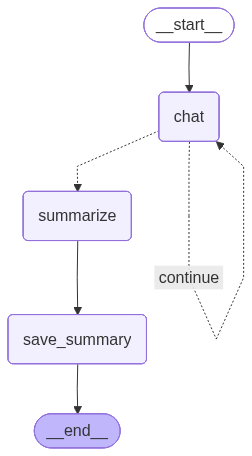

In [22]:
conversation_graph

## 실습: 요약 기능이 있는 대화



In [24]:
print("💬 대화를 시작합니다. 종료하려면 'END'를 입력하세요.\n")

config = {
    'configurable': {
        'thread_id': 'session-001',
        'user_id': 'user_kim'
    }
}

# 첫 메시지
first_msg = input("💬 You: ")
initial_messages = [HumanMessage(content=first_msg)]

# 그래프 실행
for event in conversation_graph.stream(
    {'messages': initial_messages},
    config,
    stream_mode="updates"
):
    pass  # 노드 내부에서 출력 처리

print("\n✅ 대화 종료")

💬 대화를 시작합니다. 종료하려면 'END'를 입력하세요.


🤖 AI: 안녕하세요! 무엇을 도와드릴까요?

🤖 AI: 서울의 위도는 대략 37.5665° N (북위 37.5665도) 입니다.

🤖 AI: 도쿄의 위도는 대략 35.6895° N (북위 35.6895도) 입니다.

💾 요약 저장 완료: 저는 사용자에게 인사를 건네고, 무엇을 도와드릴지 질문했습니다. 사용자는 서울의 위도를 물...

✅ 대화 종료


## 저장된 요약 확인

In [25]:
# 사용자별 요약 조회
user_namespace = ('user_kim', 'summaries')
saved_summaries = memory_store.search(user_namespace)

print("\n📚 저장된 대화 요약 목록:\n")
for i, item in enumerate(saved_summaries, 1):
    print(f"{i}. {item.value.get('summary', '')}")
    print(f"   (저장 시간: {item.created_at})\n")


📚 저장된 대화 요약 목록:

1. 저는 사용자에게 인사를 건네고, 무엇을 도와드릴지 질문했습니다. 사용자는 서울의 위도를 물었고, 저는 북위 37.5665도라고 답변했습니다. 이어서 사용자는 도쿄의 위도를 물었고, 저는 북위 35.6895도라고 답변했습니다. 대화는 서울과 도쿄의 위도 정보를 제공하는 것으로 마무리되었습니다.
   (저장 시간: 2025-12-29 04:37:00.133465+00:00)



---

# 🎓 학습 요약

## 배운 내용

### 1. MemorySaver
- RAM 기반 임시 메모리
- 테스트 및 개발에 적합
- 체크포인트로 과거 시점 복원 가능

### 2. SqliteSaver
- 파일 기반 영구 메모리
- 실전 프로젝트에 사용
- 프로그램 재시작 후에도 데이터 유지

### 3. InMemoryStore
- 구조화된 데이터 저장
- 네임스페이스로 분류
- ID 기반 CRUD 작업

### 4. 의미 기반 검색
- 임베딩 모델 활용
- 자연어 질의 가능
- 유사도 기반 검색

### 5. 대화 요약 & 장기 기억
- 자동 대화 요약
- 사용자별 요약 저장
- 이전 맥락 활용

---

## 다음 단계

- 실제 프로젝트에 적용해보기
- 다양한 저장소 조합 실험
- 커스텀 체크포인터 구현
- 분산 환경에서의 메모리 관리